In [1]:
import os
path_folder=r'C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi'
os.chdir(path_folder)

In [2]:
import matplotlib.pyplot as plt
from fbm import FBM
import numpy as np
import pandas as pd

from rbergomi import rBergomi
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)

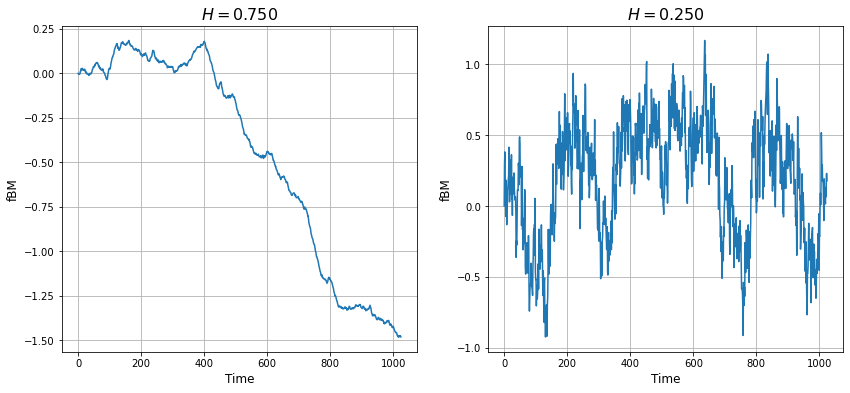

In [3]:
# Define the object
f1 = FBM(n=1024, hurst=0.75, length=1, method='cholesky')
f2 = FBM(n=1024, hurst=0.25, length=1, method='cholesky')

# Generate a fBm realization
fbm_sample_1 = f1.fbm()
fbm_sample_2 = f2.fbm()

# Plot
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(fbm_sample_1)
title = r'$H=%.3f$'
plt.title(title%(f1.hurst), fontsize=16)
plt.ylabel("fBM", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(fbm_sample_2)
title = r'$H=%.3f$'
plt.title(title%(f2.hurst), fontsize=16)
plt.ylabel("fBM", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.grid(True)

In [4]:
def rbergomi_s(spot, strikes, texp, alpha, eta, rho, xi):
    
    # to ensure computation works, we have to give greater granularity for very short durations.
    # However, setting finer granularity affects shape of smile significantly. What is the explanation?
    if texp < 0.01:
        steps_year = 100000
    else:
        steps_year = 100

    # Defining the Fractional Brownian Process and Resulting Price Process
    np.random.seed(4)
    rB = rBergomi(n = steps_year, N = 30000, T = texp, a = alpha)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = xi, eta = eta)
    S = rB.S(V, dB)
    
    # rBergomi Implied Volatilities and Call Prices
    ST = S[:,-1][:,np.newaxis]
    ST = ST*spot
    K = strikes #(np.exp(k)*spot)[np.newaxis,:]
    call_payoffs = np.maximum(ST - K,0)
    call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    implied_vols_ben_theor = vec_bsinv(call_prices, spot, np.transpose([K]), rB.T)
    
    return implied_vols_ben_theor, call_prices

In [6]:
spot=1.
strikes = np.arange(-2.5,2.5,0.1)
alpha = -0.35
eta = 2.5
rho = -0.7
xi = 0.15

texp_list = np.arange(0.002,3,0.1)
df_ivs = pd.DataFrame(columns=np.flip(texp_list), index=strikes)
df_ivs.head()

for i, texp in enumerate(df_ivs.columns.values):
    
    ivs, c0 = rbergomi_s(spot, strikes, texp, alpha, eta, rho, xi)
    ivs = np.squeeze(ivs)
    ivs[ivs==1.e-19] = np.nan
    df_ivs[texp] = ivs

C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\utils.py:42: RuntimeWarning: invalid value encountered in log
  d1 = np.log(F/K) / sv + 0.5 * sv
C:\Users\Borsti\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [33]:

# # Instantiate Plot
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=30., azim=-5)

# # Assign Values to Axes
# X = df_ivs.columns.values
# Y = strikes #df_ivs.index.values
# Y= np.flip(Y)
# X, Y = np.meshgrid(X, Y)
# Z = df_ivs.values.astype(dtype=np.float64) #np.sin(R)

# # Plot ImpVolSurface
# ax.plot_surface(X, Y, Z, alpha=0.9)
# #max_vol = np.max(np.max(df_ivs))
# #ax.set_zlim(0., max_vol*1.2)
# ax.set_xlabel("Time to Maturity in Years")
# ax.set_ylabel("Log-Strike Prices")
# ax.set_zlabel('Implied Volatility')
# #plt.title("{}".format(option_contract_df[0]))
# plt.show()

In [31]:
df_new =df_ivs[(df_ivs.index>.2)&(df_ivs.index<2.5)]

<ipython-input-32-5aeb2caf5242>:15: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, Z, alpha=0.9)


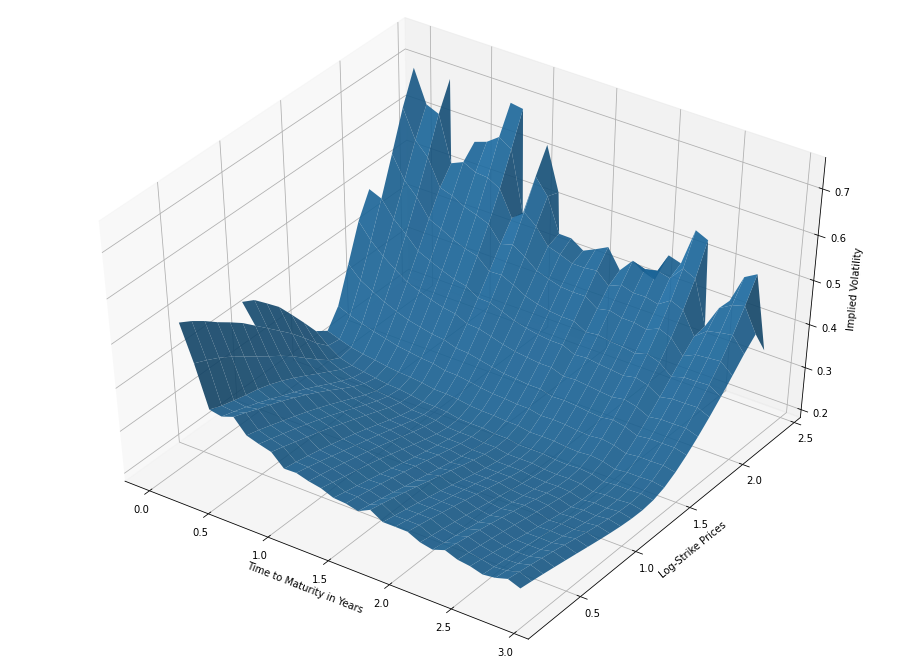

In [32]:
df = df_new
# Instantiate Plot
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45., azim=-55)

# Assign Values to Axes
X = df.columns.values
Y = df.index #df_ivs.index.values
Y= np.flip(Y)
X, Y = np.meshgrid(X, Y)
Z = df.values.astype(dtype=np.float64) #np.sin(R)

# Plot ImpVolSurface
ax.plot_surface(X, Y, Z, alpha=0.9)
#max_vol = np.max(np.max(df_ivs))
#ax.set_zlim(0., max_vol*1.2)
ax.set_xlabel("Time to Maturity in Years")
ax.set_ylabel("Log-Strike Prices")
ax.set_zlabel('Implied Volatility')
#plt.title("{}".format(option_contract_df[0]))
plt.show()